In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Flatten, Dropout, Activation
from keras.layers.convolutional import ZeroPadding2D, Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, 
                                   target_size=target_size, 
                                   class_mode=class_mode, 
                                   shuffle=shuffle, 
                                   batch_size=batch_size)
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    classes = batches.classes
    filenames = batches.filenames
    return np.concatenate([batches.next() for i in range(batches.samples)]), classes, onehot(classes), filenames

In [25]:
trn, trn_classes, trn_labels, trn_filenames = get_data('training', (360, 640))
val, val_classes, val_labels, val_filenames = get_data('validation', (360, 640))

Found 3025 images belonging to 8 classes.
Found 752 images belonging to 8 classes.


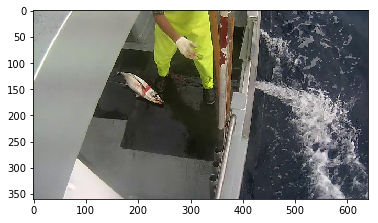

In [5]:
plt.imshow(np.rollaxis(val[0], 0, 3).astype(np.uint8))

In [14]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [8]:
save_array('trn_640.dat', trn)
save_array('val_640.dat', val)

In [9]:
trn = load_array('trn_640.dat')
val = load_array('val_640.dat')

In [8]:
VGG_MEAN = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
def preprocessing(img):
    img = img - VGG_MEAN
    return img

model = Sequential()
model.add(Lambda(preprocessing, input_shape=(3, 360, 640), output_shape=(3, 360, 640)))
# Layer 1
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# model.load_weights('vgg16_bn_conv.h5')
model.load_weights('vgg16_bn_conv_tf.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 360, 640)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 362, 642)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 360, 640)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 362, 642)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 360, 640)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 180, 320)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 182, 322)      0         
__________

In [17]:
from keras import backend as K
from keras.utils.conv_utils import convert_kernel
import tensorflow as tf

ops = []
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv1D', 'Conv2D', 'Conv3D']:
        print('convert Conv2D')
        original_w = K.get_value(layer.kernel)
        converted_w = convert_kernel(original_w)
        ops.append(tf.assign(layer.kernel, converted_w).op)
K.get_session().run(ops)
model.save_weights('vgg16_bn_conv_tf.h5')

convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D
convert Conv2D


In [18]:
model.pop()
print(model.input_shape, model.output_shape)
model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

(None, 3, 360, 640) (None, 512, 22, 40)


In [26]:
conv_val_feat = model.predict(val, batch_size=8, verbose=1)
conv_trn_feat = model.predict(trn, batch_size=8, verbose=1)

3025/3025 [==============================] - 344s   


In [27]:
save_array('conv_val_640.dat', conv_val_feat)
save_array('conv_trn_640.dat', conv_trn_feat)

In [22]:
conv_val_feat = load_array('conv_val_640.dat')
conv_trn_feat = load_array('conv_trn_640.dat')

# fc model

In [142]:
def get_fc_layers(nf=128, p=0.):
    return [
        BatchNormalization(axis=1, input_shape=model.output_shape[1:]),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Conv2D(8,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]
fc_model = Sequential(get_fc_layers())
fc_model.summary()
fc_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_13 (Batc (None, 512, 11, 20)       2048      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 11, 20)       589952    
_________________________________________________________________
batch_normalization_14 (Batc (None, 128, 11, 20)       512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 5, 10)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 5, 10)        147584    
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 5, 10)        512       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 2, 5)         0         
__________

In [143]:
fc_model.fit(conv_trn_feat, trn_labels, batch_size=16, epochs=10, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 9s - loss: 0.5762 - acc: 0.8221 - val_loss: 0.6050 - val_acc: 0.8231
Epoch 2/10
3025/3025 [==============================] - 8s - loss: 0.1015 - acc: 0.9712 - val_loss: 0.2246 - val_acc: 0.9295
Epoch 3/10
3025/3025 [==============================] - 8s - loss: 0.0530 - acc: 0.9861 - val_loss: 0.1186 - val_acc: 0.9694
Epoch 4/10
3025/3025 [==============================] - 8s - loss: 0.0927 - acc: 0.9742 - val_loss: 0.2749 - val_acc: 0.9282
Epoch 5/10
3025/3025 [==============================] - 8s - loss: 0.0642 - acc: 0.9815 - val_loss: 0.2459 - val_acc: 0.9495
Epoch 6/10
3025/3025 [==============================] - 8s - loss: 0.0190 - acc: 0.9944 - val_loss: 0.1306 - val_acc: 0.9681
Epoch 7/10
3025/3025 [==============================] - 8s - loss: 0.0050 - acc: 0.9993 - val_loss: 0.1102 - val_acc: 0.9747
Epoch 8/10
3025/3025 [==============================] - 8s - loss: 7.0353e-04 

In [34]:
fc_model.save_weights('lrg_nmp.h5')

In [139]:
fc_model.load_weights('lrg_nmp.h5')

In [65]:
l = fc_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [66]:
import scipy

def get_cm(inp, label):
    conv = np.max(conv_fn([inp,0])[0][label], axis=0)
    print(conv.shape)
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

In [72]:
i = 7
inp = np.expand_dims(conv_val_feat[i], 0)
np.round(fc_model.predict(inp)[0],2)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

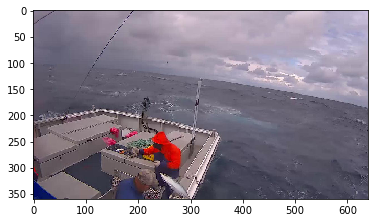

In [73]:
plt.imshow(np.rollaxis(val[i], 0, 3).astype(np.uint8))

(22, 40)


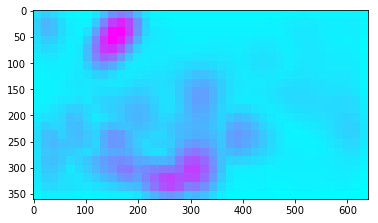

In [74]:
cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

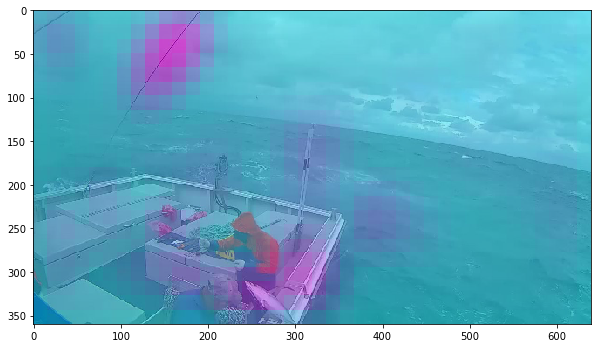

In [75]:
# cancel maxpooling layer to get high-resolution map
plt.figure(figsize=(10,10))
plt.imshow(np.rollaxis(val[i], 0, 3).astype(np.uint8))
plt.imshow(cm, cmap="cool", alpha=0.5)

## inception mini-net

In [85]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, strides=(1, 1)):
    x = Conv2D(nb_filter, (nb_row, nb_col), strides=strides, activation='relu', padding='same')(x)
    return BatchNormalization(axis=1)(x)

def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, strides=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, strides=(2, 2))

    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, strides=(2, 2))
    
    branch_pool = AveragePooling2D((3, 3), strides=(2, 2), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=1)

inp = Input(model.output_shape[1:]) # after vgg_large model
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Conv2D(8,(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)
incep_model = Model([inp], outp)
incep_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 512, 22, 40)   0                                            
____________________________________________________________________________________________________
batch_normalization_63 (BatchNor (None, 512, 22, 40)   2048        input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_97 (Conv2D)               (None, 32, 22, 40)    16416       batch_normalization_63[0][0]     
____________________________________________________________________________________________________
batch_normalization_65 (BatchNor (None, 32, 22, 40)    128         conv2d_97[0][0]                  
___________________________________________________________________________________________

In [86]:
incep_model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
incep_model.fit(conv_trn_feat, trn_labels, batch_size=16, epochs=2, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/2
3025/3025 [==============================] - 47s - loss: 1.1516 - acc: 0.6235 - val_loss: 0.6958 - val_acc: 0.8324
Epoch 2/2
3025/3025 [==============================] - 44s - loss: 0.4117 - acc: 0.8817 - val_loss: 0.2605 - val_acc: 0.9229


In [88]:
incep_model.fit(conv_trn_feat, trn_labels, batch_size=16, epochs=10, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 45s - loss: 0.2067 - acc: 0.9336 - val_loss: 0.2727 - val_acc: 0.9215
Epoch 2/10
3025/3025 [==============================] - 44s - loss: 0.1053 - acc: 0.9683 - val_loss: 0.2919 - val_acc: 0.9282
Epoch 3/10
3025/3025 [==============================] - 44s - loss: 0.1750 - acc: 0.9471 - val_loss: 0.2694 - val_acc: 0.9215
Epoch 4/10
3025/3025 [==============================] - 44s - loss: 0.0807 - acc: 0.9779 - val_loss: 0.1892 - val_acc: 0.9455
Epoch 5/10
3025/3025 [==============================] - 44s - loss: 0.1039 - acc: 0.9689 - val_loss: 0.3049 - val_acc: 0.9269
Epoch 6/10
3025/3025 [==============================] - 44s - loss: 0.1083 - acc: 0.9636 - val_loss: 0.2189 - val_acc: 0.9508
Epoch 7/10
3025/3025 [==============================] - 44s - loss: 0.0459 - acc: 0.9855 - val_loss: 0.2155 - val_acc: 0.9481
Epoch 8/10
3025/3025 [==============================] - 44s - loss: 0.0

In [89]:
incep_model.optimizer.lr = 1e-5
incep_model.fit(conv_trn_feat, trn_labels, batch_size=16, epochs=10, validation_data=(conv_val_feat, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - 45s - loss: 0.0534 - acc: 0.9831 - val_loss: 0.2064 - val_acc: 0.9535
Epoch 2/10
3025/3025 [==============================] - 44s - loss: 0.0279 - acc: 0.9917 - val_loss: 0.1706 - val_acc: 0.9574
Epoch 3/10
3025/3025 [==============================] - 44s - loss: 0.0237 - acc: 0.9931 - val_loss: 0.1975 - val_acc: 0.9614
Epoch 4/10
3025/3025 [==============================] - 44s - loss: 0.0164 - acc: 0.9937 - val_loss: 0.1750 - val_acc: 0.9601
Epoch 5/10
3025/3025 [==============================] - 44s - loss: 0.0126 - acc: 0.9960 - val_loss: 0.2014 - val_acc: 0.9588
Epoch 6/10
3025/3025 [==============================] - 44s - loss: 0.0134 - acc: 0.9957 - val_loss: 0.2143 - val_acc: 0.9588
Epoch 7/10
3025/3025 [==============================] - 44s - loss: 0.1092 - acc: 0.9603 - val_loss: 0.2981 - val_acc: 0.9335
Epoch 8/10
3025/3025 [==============================] - 44s - loss: 0.0

In [91]:
incep_model.save_weights('incep.h5')

In [ ]:
incep_model.load_weights('incep.h5')

## pseudo labeling

In [4]:
test, test_classes, test_labels, test_filenames = get_data('testing', (360, 640))

Found 13153 images belonging to 2 classes.


MemoryError: 

In [9]:
batches = get_batches('testing', shuffle=False, batch_size=1, class_mode=None, target_size=(360, 640))
test_filenames = batches.filenames
converted = 0
conv_test_feat = []
test = np.concatenate([batches.next() for i in range(batches.samples//4)])
conv_test_feat.append(model.predict(test, batch_size=8, verbose=1))
converted += batches.samples//4
test = np.concatenate([batches.next() for i in range(batches.samples//4)])
conv_test_feat.append(model.predict(test, batch_size=8, verbose=1))
converted += batches.samples//4
test = np.concatenate([batches.next() for i in range(batches.samples//4)])
conv_test_feat.append(model.predict(test, batch_size=8, verbose=1))
converted += batches.samples//4
test = np.concatenate([batches.next() for i in range(batches.samples-converted)])
conv_test_feat.append(model.predict(test, batch_size=8, verbose=1))

Found 13153 images belonging to 2 classes.
3289/3289 [==============================] - 375s   


In [12]:
conv_test_feat = np.concatenate(conv_test_feat, axis=0)
conv_test_feat.shape

(13153, 512, 11, 20)

In [16]:
save_array('conv_test_640.dat', conv_test_feat)

In [ ]:
conv_test_feat = load_array('conv_test_640.dat')

In [149]:
preds = fc_model.predict(conv_test_feat, batch_size=64, verbose=1)

13153/13153 [==============================] - 16s    


In [148]:
fc_model.evaluate(conv_val_feat, val_labels, verbose=1)

752/752 [==============================] - 1s     


[0.10600735739794896, 0.97739361702127658]

In [145]:
val_preds = fc_model.predict(conv_val_feat, batch_size=64, verbose=1)

752/752 [==============================] - 1s     


In [89]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.N = sum([it.batch_size for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def __next__(self):
        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)


In [152]:
from keras.preprocessing.image import Iterator
from keras import backend as K

class CustomizedArrayIterator(Iterator):
    def __init__(self, x, y, batch_size=32, shuffle=True, seed=None):
        self.x = np.asarray(x, dtype=K.floatx())
        self.y = np.asarray(y)
        super(CustomizedArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)
    def _get_batches_of_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]), dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            batch_x[i] = x
        batch_y = self.y[index_array]
        return batch_x, batch_y
    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        #print(index_array)
        return self.x[index_array[0]], self.y[index_array[0]]
#gen = image.ImageDataGenerator()
#test_batches = gen.flow(conv_test_feat, preds, batch_size=16)
test_batches = CustomizedArrayIterator(conv_test_feat, preds, batch_size=16)
#val_batches = gen.flow(conv_val_feat, val_preds, batch_size=4)
val_batches = CustomizedArrayIterator(conv_val_feat, val_labels, batch_size=4)
#trn_batches = gen.flow(conv_trn_feat, trn_labels, batch_size=44)
trn_batches = CustomizedArrayIterator(conv_trn_feat, trn_labels, batch_size=44)
mi = MixIterator([trn_batches, val_batches, test_batches])

In [108]:
mi.reset()
a, b = next(mi)
a.shape, b.shape, trn_batches.n//trn_batches.batch_size

((16, 512, 11, 20), (16, 8), 252)

In [153]:
mi.reset()
fc_model.fit_generator(trn_batches, trn_batches.n//trn_batches.batch_size, epochs=10, validation_data=(conv_val_feat, val_labels))

Epoch 1/10
68/68 [==============================] - 7s - loss: 5.4209e-05 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9761
Epoch 2/10
68/68 [==============================] - 6s - loss: 5.0914e-05 - acc: 1.0000 - val_loss: 0.1076 - val_acc: 0.9761
Epoch 3/10
68/68 [==============================] - 6s - loss: 5.7468e-05 - acc: 1.0000 - val_loss: 0.1079 - val_acc: 0.9747
Epoch 4/10
68/68 [==============================] - 6s - loss: 4.6439e-05 - acc: 1.0000 - val_loss: 0.1081 - val_acc: 0.9761
Epoch 5/10
68/68 [==============================] - 6s - loss: 4.3073e-05 - acc: 1.0000 - val_loss: 0.1086 - val_acc: 0.9761
Epoch 6/10
68/68 [==============================] - 6s - loss: 4.5644e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9761
Epoch 7/10
68/68 [==============================] - 6s - loss: 4.3734e-05 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9761
Epoch 8/10
68/68 [==============================] - 6s - loss: 3.9577e-05 - acc: 1.0000 - val_loss: 0.1089 - val_acc: 0.9747


In [154]:
fc_model.optimizer.lr=1e-6
mi.reset()
fc_model.fit_generator(mi, trn_batches.n//trn_batches.batch_size, epochs=10, validation_data=(conv_val_feat, val_labels))

Epoch 1/10
68/68 [==============================] - 9s - loss: 0.2737 - acc: 0.9469 - val_loss: 0.1379 - val_acc: 0.9747
Epoch 2/10
68/68 [==============================] - 9s - loss: 0.2931 - acc: 0.9318 - val_loss: 0.0970 - val_acc: 0.9801
Epoch 3/10
68/68 [==============================] - 9s - loss: 0.2835 - acc: 0.9365 - val_loss: 0.0151 - val_acc: 0.9960
Epoch 4/10
68/68 [==============================] - 9s - loss: 0.2664 - acc: 0.9408 - val_loss: 0.0103 - val_acc: 1.0000
Epoch 5/10
68/68 [==============================] - 9s - loss: 0.2685 - acc: 0.9428 - val_loss: 0.0078 - val_acc: 0.9987
Epoch 6/10
68/68 [==============================] - 9s - loss: 0.2614 - acc: 0.9455 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 7/10
68/68 [==============================] - 9s - loss: 0.2566 - acc: 0.9482 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 8/10
68/68 [==============================] - 9s - loss: 0.2529 - acc: 0.9530 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 9/10
68/68 [==============